**LIBRARIES AND SETUP**

Description: This cell imports necessary libraries and sets up the environment for model training.

In [1]:
# CICIDS2017 Random Forest Training - Optimized for Google Colab
# Focused on Random Forest for Traffic Classification and Operator Detection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import joblib
import warnings
import time
import os
from datetime import datetime

warnings.filterwarnings('ignore')

print("CICIDS2017 Random Forest Training Pipeline")
print("=" * 50)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

CICIDS2017 Random Forest Training Pipeline
Start time: 2025-05-29 22:43:20


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Configuration**

Description:
 Define paths for accessing preprocessed data (features, scalers, train-test splits) and for saving training outputs (models, results, plots). Also ensures output directories exist.

In [3]:
RANDOM_STATE = 42
# Input paths (from preprocessing)
PREPROCESSED_DATA_PATH = '/content/drive/MyDrive/furssah/preprocessing_output/'
PREPROCESSED_MODELS_PATH = os.path.join(PREPROCESSED_DATA_PATH, 'models')
PREPROCESSED_FEATURES_PATH = os.path.join(PREPROCESSED_DATA_PATH, 'features')
PREPROCESSED_SPLITS_PATH = os.path.join(PREPROCESSED_DATA_PATH, 'train_test_splits')

# Output paths (for this training phase)
TRAINING_OUTPUT_BASE = f'/content/drive/MyDrive/furssah/training_output/'
TRAINING_PATHS = {
    'models': os.path.join(TRAINING_OUTPUT_BASE, 'trained_models'),
    'results': os.path.join(TRAINING_OUTPUT_BASE, 'results'),
    'visualizations': os.path.join(TRAINING_OUTPUT_BASE, 'visualizations'),
    'feature_analysis': os.path.join(TRAINING_OUTPUT_BASE, 'feature_analysis')
}

# Create directories if they don't exist
for path in TRAINING_PATHS.values():
    os.makedirs(path, exist_ok=True)

**1. LOAD PREPROCESSED DATA**

Description:
This cell loads the necessary data and preprocessing components required for training models.
 It loads:
  - Feature names
  - Scaler used for normalization
  - Label encoders for categorical outputs
  - Pre-split training and testing datasets for multiple classification tasks:
    'attack_type', 'traffic_source', and 'operator_type'

In [4]:
print("\nLoading preprocessed data...")
start_load_time = time.time()

try:
    # Load feature names
    with open(os.path.join(PREPROCESSED_FEATURES_PATH, 'feature_names.txt'), 'r') as f:
        feature_names = [line.strip() for line in f.readlines()]

    # Load scaler and label encoders
    scaler = joblib.load(os.path.join(PREPROCESSED_MODELS_PATH, 'scaler.joblib'))
    label_encoders = joblib.load(os.path.join(PREPROCESSED_MODELS_PATH, 'label_encoders.joblib'))

    print(f"✓ Loaded {len(feature_names)} features")
    print(f"✓ Loaded {len(label_encoders)} label encoders")

except FileNotFoundError as e:
    print(f" Error loading preprocessing files: {e}")
    print("Make sure you have run the preprocessing step first!")
    exit(1)

# Load train-test splits for different tasks
tasks = ['attack_type', 'traffic_source', 'operator_type']
data_splits = {}
total_samples = 0

for task in tasks:
    try:
        X_train = pd.read_csv(os.path.join(PREPROCESSED_SPLITS_PATH, f"{task}_X_train.csv"))
        X_test = pd.read_csv(os.path.join(PREPROCESSED_SPLITS_PATH, f"{task}_X_test.csv"))
        y_train = pd.read_csv(os.path.join(PREPROCESSED_SPLITS_PATH, f"{task}_y_train.csv")).iloc[:, 0]
        y_test = pd.read_csv(os.path.join(PREPROCESSED_SPLITS_PATH, f"{task}_y_test.csv")).iloc[:, 0]

        data_splits[task] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        }

        task_samples = len(X_train) + len(X_test)
        total_samples += task_samples

        print(f"✓ Loaded {task}: Train={len(X_train):,}, Test={len(X_test):,}")
        print(f"  Classes: {sorted(y_train.unique())}")

    except FileNotFoundError:
        print(f"  Warning: Data for {task} not found, skipping...")

load_time = time.time() - start_load_time
print(f"\nData loading completed in {load_time:.2f} seconds")
print(f"Total samples across all tasks: {total_samples:,}")


Loading preprocessed data...
✓ Loaded 7 features
✓ Loaded 3 label encoders
✓ Loaded attack_type: Train=80,000, Test=20,000
  Classes: ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack � Brute Force', 'Web Attack � XSS']
✓ Loaded traffic_source: Train=80,000, Test=20,000
  Classes: ['BENIGN', 'MALICIOUS']
✓ Loaded operator_type: Train=80,000, Test=20,000
  Classes: ['AUTOMATED', 'BENIGN', 'HUMAN']

Data loading completed in 6.22 seconds
Total samples across all tasks: 300,000


**2. RANDOM FOREST CONFIGURATION**

Description & Explanation:
This function **get_rf_config()** returns an optimized Random Forest configuration and a hyperparameter grid based on the dataset size and task type.

 - Adapts model settings (like tree depth, number of trees) depending on whether the dataset is small, medium, or large.

 - Also defines a parameter grid for tuning during model optimization (e.g., GridSearchCV).

 - Helps balance performance and training speed based on available data.

In [5]:
def get_rf_config(task_name, sample_size):
    """Get optimized Random Forest configuration based on task and data size"""

    # Base configuration
    base_config = {
        'random_state': RANDOM_STATE,
        'n_jobs': -1,  # Use all available cores
        'verbose': 1,  # Show progress
        'warm_start': False
    }

    # Adjust parameters based on data size and task complexity
    if sample_size < 100000:  # Small dataset
        config = {
            **base_config,
            'n_estimators': 100,
            'max_depth': 15,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 'sqrt'
        }
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 15, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    elif sample_size < 500000:  # Medium dataset
        config = {
            **base_config,
            'n_estimators': 200,
            'max_depth': 20,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 'sqrt'
        }
        param_grid = {
            'n_estimators': [150, 200],
            'max_depth': [15, 20, None],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4]
        }
    else:  # Large dataset
        config = {
            **base_config,
            'n_estimators': 150,  # Reduced for speed
            'max_depth': 25,
            'min_samples_split': 10,
            'min_samples_leaf': 4,
            'max_features': 'sqrt'
        }
        param_grid = {
            'n_estimators': [100],
            'max_depth': [10, 15],
            'min_samples_split': [5],
            'min_samples_leaf': [2]
        }

    return config, param_grid

**3. TRAINING TIME ESTIMATION**

Description & Explanation:
This function **estimate_training_time()** gives a rough estimate of how long it will take to train a Random Forest model.

-  It calculates training time based on:

    * Number of samples, features, and classes
    * Assumes training on CPU (e.g., Google Colab)   
    * Adds a complexity factor for higher-dimensional or multi-class tasks
    * Multiplies by the number of grid search combinations (≈12)

-  Useful for planning time before actual training, especially when tuning with GridSearch

In [6]:
def estimate_training_time(X_train, y_train, task_name):
    """Estimate training time for Random Forest"""

    n_samples = len(X_train)
    n_features = X_train.shape[1]
    n_classes = len(np.unique(y_train))

    # Base time estimation (very rough approximation)
    # These are empirical estimates for Google Colab (T4 GPU, but RF uses CPU)
    base_time_per_sample = 0.0001  # seconds per sample for basic RF
    complexity_factor = 1.0

    # Adjust based on number of features
    if n_features > 50:
        complexity_factor *= 1.5
    if n_features > 100:
        complexity_factor *= 1.3

    # Adjust based on number of classes
    if n_classes > 5:
        complexity_factor *= 1.2
    if n_classes > 10:
        complexity_factor *= 1.3

    # Grid search multiplier (approximately 12 combinations)
    grid_search_combinations = 12

    estimated_time = (n_samples * base_time_per_sample * complexity_factor *
                     grid_search_combinations)

    return estimated_time

**4. RANDOM FOREST TRAINING FUNCTION**

1. This function trains a Random Forest model with optional GridSearch for hyperparameter tuning based on dataset size:

      * Small/Medium data → Runs GridSearchCV for best parameters.
      * Large data → Skips tuning for faster training.

2. It:

      * Estimates training time.
      * Trains the model.
      * Predicts and evaluates using accuracy, F1-score, and cross-validation.
      * Returns the trained model, metrics, and timings.

In [7]:
def train_random_forest(X_train, X_test, y_train, y_test, task_name, use_grid_search=True):
    """Train Random Forest with optimized parameters"""

    print(f"\n{'='*20} Training Random Forest for {task_name.upper()} {'='*20}")

    sample_size = len(X_train)
    rf_config, param_grid = get_rf_config(task_name, sample_size)

    # Estimate training time
    estimated_time = estimate_training_time(X_train, y_train, task_name)
    print(f"Dataset info: {sample_size:,} samples, {X_train.shape[1]} features, {len(np.unique(y_train))} classes")
    print(f"Estimated training time: {estimated_time:.1f} seconds ({estimated_time/60:.1f} minutes)")

    start_time = time.time()

    if use_grid_search and sample_size < 1000000:  # Skip grid search for very large datasets
        print("Starting hyperparameter tuning with GridSearchCV...")

        # Create base model
        rf_base = RandomForestClassifier(**rf_config)

        # Grid search with reduced CV for speed
        grid_search = GridSearchCV(
            rf_base, param_grid,
            cv=3,  # Reduced from 5 for speed
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        print(f" Best parameters found: {grid_search.best_params_}")
        print(f" Best CV score: {grid_search.best_score_:.4f}")

    else:
        print("Training with optimized default parameters (skipping grid search for speed)...")
        best_model = RandomForestClassifier(**rf_config)
        best_model.fit(X_train, y_train)

    training_time = time.time() - start_time
    print(f"Actual training time: {training_time:.1f} seconds ({training_time/60:.1f} minutes)")

    # Make predictions
    print("Making predictions...")
    pred_start = time.time()

    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)

    pred_time = time.time() - pred_start
    print(f"Prediction time: {pred_time:.2f} seconds")

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')

    # Cross-validation (quick evaluation)
    print("Running cross-validation...")
    cv_start = time.time()
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
    cv_time = time.time() - cv_start

    results = {
        'model': best_model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_predictions': test_pred,
        'training_time': training_time,
        'prediction_time': pred_time,
        'cv_time': cv_time,
        'classification_report': classification_report(y_test, test_pred, output_dict=True)
    }

    # Print results
    print(f"\   RESULTS FOR {task_name.upper()}:")
    print(f"   Train Accuracy: {train_accuracy:.4f}")
    print(f"   Test Accuracy:  {test_accuracy:.4f}")
    print(f"   Train F1:       {train_f1:.4f}")
    print(f"   Test F1:        {test_f1:.4f}")
    print(f"   CV F1:          {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"   Total time:     {training_time + pred_time + cv_time:.1f} seconds")

    return results


**5. TRAIN MODELS FOR ALL TASKS**

This script trains Random Forest models for all tasks in data_splits (ATTACK_TYPE,TRAFFIC_SOURCE,OPERATOR_TYPE):

- Estimates total training time and prints a completion forecast.

- Loops through each task:

    * Trains the model using train_random_forest()
    * Saves the trained model with joblib
    * Cleans memory after each task

- Tracks and prints the total training time.

In [8]:
print("\n" +  "="*48 )
print("STARTING RANDOM FOREST TRAINING")
print("="*48 )

all_results = {}
total_training_time = 0

# Calculate total estimated time
total_estimated_time = 0
for task_name, task_data in data_splits.items():
    est_time = estimate_training_time(task_data['X_train'], task_data['y_train'], task_name)
    total_estimated_time += est_time

print(f"\n  TRAINING OVERVIEW:")
print(f"   Tasks to train: {len(data_splits)}")
print(f"   Total estimated time: {total_estimated_time:.1f} seconds ({total_estimated_time/60:.1f} minutes)")
print(f"   Estimated completion: {datetime.now().replace(second=0, microsecond=0) + pd.Timedelta(seconds=total_estimated_time)}")

for task_name, task_data in data_splits.items():
    try:
        # Train Random Forest
        results = train_random_forest(
            task_data['X_train'], task_data['X_test'],
            task_data['y_train'], task_data['y_test'],
            task_name, use_grid_search=True
        )

        all_results[task_name] = results
        total_training_time += results['training_time']

        # Save the trained model
        model_filename = os.path.join(TRAINING_PATHS['models'], f"{task_name}_random_forest_model.joblib")
        joblib.dump(results['model'], model_filename)
        print(f"Model saved: {model_filename}")

        # Memory cleanup
        import gc
        gc.collect()

    except Exception as e:
        print(f"Error training Random Forest for {task_name}: {str(e)}")
        continue

print(f"\n  TOTAL TRAINING TIME: {total_training_time:.1f} seconds ({total_training_time/60:.1f} minutes)")


STARTING RANDOM FOREST TRAINING

  TRAINING OVERVIEW:
   Tasks to train: 3
   Total estimated time: 341.8 seconds (5.7 minutes)
   Estimated completion: 2025-05-29 22:48:41.760000

==================== Training Random Forest for ATTACK_TYPE ====================
Dataset info: 80,000 samples, 7 features, 13 classes
Estimated training time: 149.8 seconds (2.5 minutes)
Starting hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   17.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


 Best parameters found: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
 Best CV score: 0.9801
Actual training time: 676.8 seconds (11.3 minutes)
Making predictions...


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished


Prediction time: 1.59 seconds
Running cross-validation...
\   RESULTS FOR ATTACK_TYPE:
   Train Accuracy: 0.9841
   Test Accuracy:  0.9801
   Train F1:       0.9838
   Test F1:        0.9798
   CV F1:          0.9801 (±0.0004)
   Total time:     716.6 seconds
Model saved: /content/drive/MyDrive/furssah/training_output/trained_models/attack_type_random_forest_model.joblib

==================== Training Random Forest for TRAFFIC_SOURCE ====================
Dataset info: 80,000 samples, 7 features, 2 classes
Estimated training time: 96.0 seconds (1.6 minutes)
Starting hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


 Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
 Best CV score: 0.9815
Actual training time: 589.1 seconds (9.8 minutes)
Making predictions...


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished


Prediction time: 1.16 seconds
Running cross-validation...
\   RESULTS FOR TRAFFIC_SOURCE:
   Train Accuracy: 0.9838
   Test Accuracy:  0.9805
   Train F1:       0.9839
   Test F1:        0.9806
   CV F1:          0.9815 (±0.0007)
   Total time:     623.1 seconds
Model saved: /content/drive/MyDrive/furssah/training_output/trained_models/traffic_source_random_forest_model.joblib

==================== Training Random Forest for OPERATOR_TYPE ====================
Dataset info: 80,000 samples, 7 features, 3 classes
Estimated training time: 96.0 seconds (1.6 minutes)
Starting hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   16.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


 Best parameters found: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
 Best CV score: 0.9812
Actual training time: 616.4 seconds (10.3 minutes)
Making predictions...


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished


Prediction time: 1.24 seconds
Running cross-validation...
\   RESULTS FOR OPERATOR_TYPE:
   Train Accuracy: 0.9838
   Test Accuracy:  0.9809
   Train F1:       0.9836
   Test F1:        0.9806
   CV F1:          0.9812 (±0.0012)
   Total time:     655.8 seconds
Model saved: /content/drive/MyDrive/furssah/training_output/trained_models/operator_type_random_forest_model.joblib

  TOTAL TRAINING TIME: 1882.4 seconds (31.4 minutes)


**6. RESULTS ANALYSIS**

This block summarizes and saves the evaluation metrics of all trained Random Forest models:

- Builds a summary list with:

    * Task name
    * Test accuracy & F1-score
    * Cross-validation (CV) mean & std
    * Training time (in minutes)
    * Converts summary to a DataFrame and displays it.
    * Saves results as a CSV in the configured path.

-  for comparing model performance across tasks.

In [9]:
print("\n" + "="*48 )
print("RESULTS ANALYSIS")
print("="*48 )

# Create results summary
results_summary = []
for task_name, results in all_results.items():
    results_summary.append({
        'Task': task_name,
        'Test_Accuracy': results['test_accuracy'],
        'Test_F1': results['test_f1'],
        'CV_Mean': results['cv_mean'],
        'CV_Std': results['cv_std'],
        'Training_Time_Minutes': results['training_time'] / 60
    })

if results_summary:
    results_df = pd.DataFrame(results_summary)
    print("\nRANDOM FOREST PERFORMANCE SUMMARY:")
    print(results_df.round(4).to_string(index=False))

    # Save results
    results_df.to_csv(os.path.join(TRAINING_PATHS['results'], 'random_forest_results.csv'), index=False)
    print(f"\nResults saved to: {os.path.join(TRAINING_PATHS['results'], 'random_forest_results.csv')}")


RESULTS ANALYSIS

RANDOM FOREST PERFORMANCE SUMMARY:
          Task  Test_Accuracy  Test_F1  CV_Mean  CV_Std  Training_Time_Minutes
   attack_type         0.9802   0.9798   0.9801  0.0004                11.2807
traffic_source         0.9805   0.9806   0.9815  0.0007                 9.8178
 operator_type         0.9810   0.9806   0.9812  0.0012                10.2740

Results saved to: /content/drive/MyDrive/furssah/training_output/results/random_forest_results.csv


**7. VISUALIZATION**

this block

- Plots 4 bar charts for each task:

    *  Test Accuracy  
    *  Test F1 Score
    *  Cross-Validation F1
    *  Training Time (minutes)  
    *  Displays all charts in a 2×2 grid.

- Saves the figure as random_forest_analysis.png.


  Creating visualizations...


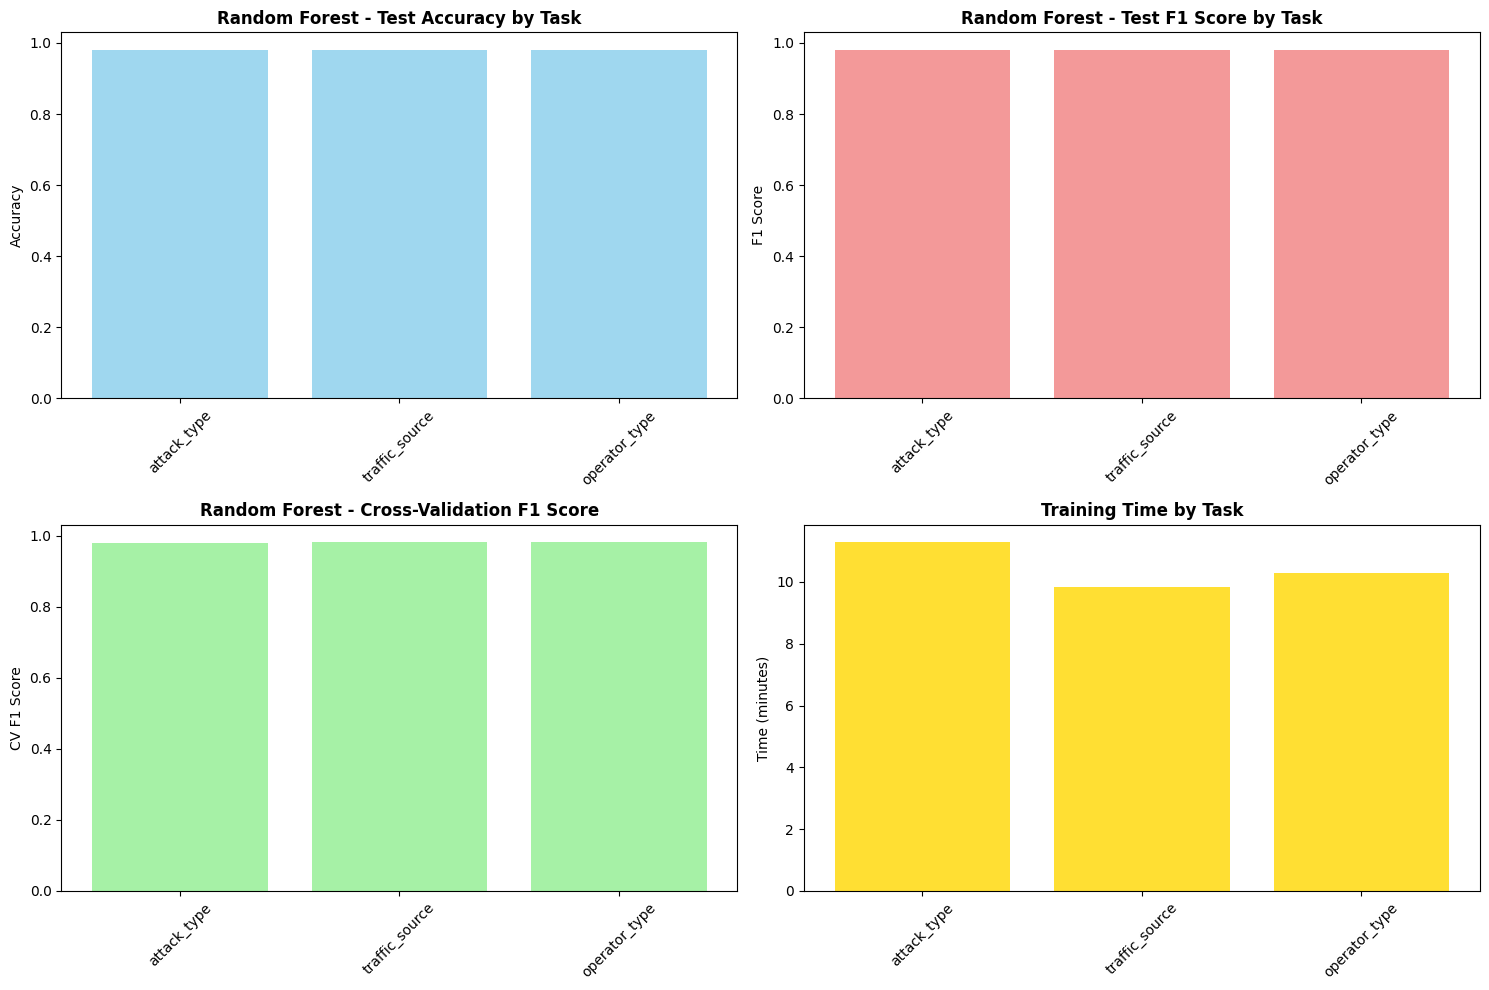

In [10]:
if results_summary:
    print("\n  Creating visualizations...")

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Performance metrics
    tasks = [r['Task'] for r in results_summary]
    test_acc = [r['Test_Accuracy'] for r in results_summary]
    test_f1 = [r['Test_F1'] for r in results_summary]
    cv_mean = [r['CV_Mean'] for r in results_summary]
    train_time = [r['Training_Time_Minutes'] for r in results_summary]

    # Test Accuracy
    axes[0,0].bar(tasks, test_acc, color='skyblue', alpha=0.8)
    axes[0,0].set_title('Random Forest - Test Accuracy by Task', fontweight='bold')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Test F1 Score
    axes[0,1].bar(tasks, test_f1, color='lightcoral', alpha=0.8)
    axes[0,1].set_title('Random Forest - Test F1 Score by Task', fontweight='bold')
    axes[0,1].set_ylabel('F1 Score')
    axes[0,1].tick_params(axis='x', rotation=45)

    # Cross-validation scores
    axes[1,0].bar(tasks, cv_mean, color='lightgreen', alpha=0.8)
    axes[1,0].set_title('Random Forest - Cross-Validation F1 Score', fontweight='bold')
    axes[1,0].set_ylabel('CV F1 Score')
    axes[1,0].tick_params(axis='x', rotation=45)

    # Training time
    axes[1,1].bar(tasks, train_time, color='gold', alpha=0.8)
    axes[1,1].set_title('Training Time by Task', fontweight='bold')
    axes[1,1].set_ylabel('Time (minutes)')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(os.path.join(TRAINING_PATHS['visualizations'], 'random_forest_analysis.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

**8. CONFUSION MATRICES**

For each task:

* Computes the confusion matrix using test labels & predictions.
* Plots a heatmap with annotations.
* Titles include task name and F1-score.
* Displays all in one row.
* Saves the figure as random_forest_confusion_matrices.png.

Useful to assess class-wise prediction performance.


  Generating confusion matrices...


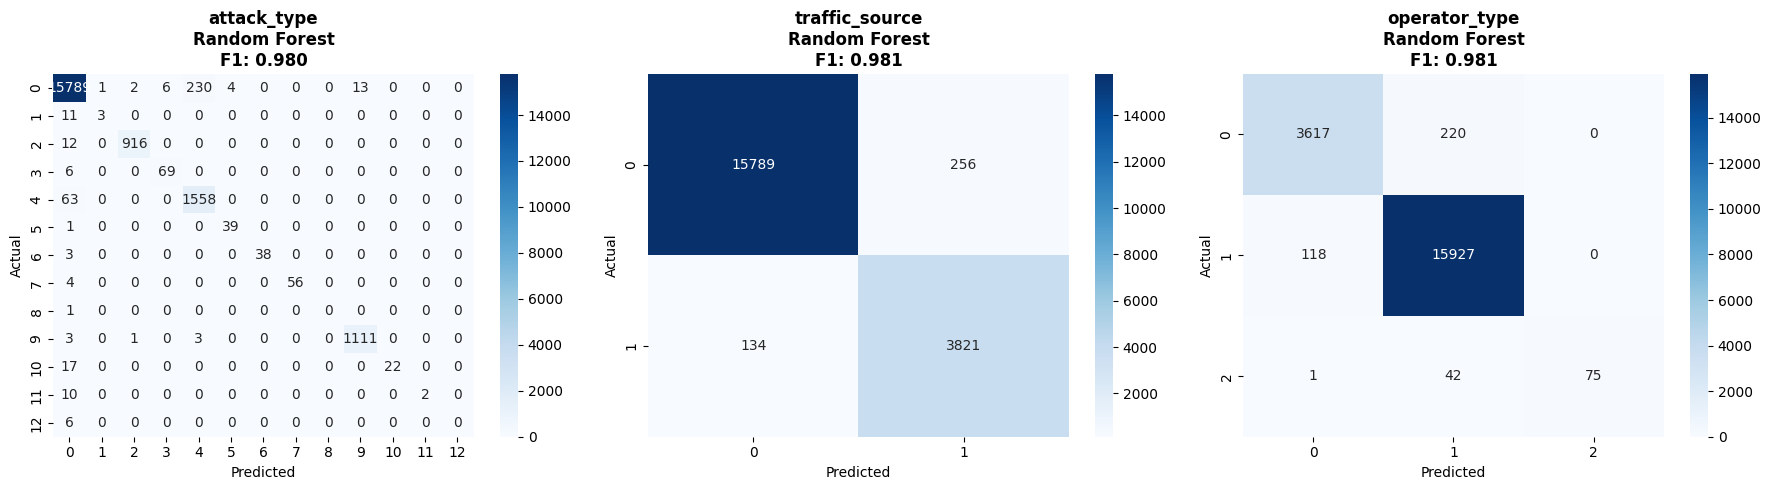

In [11]:
if all_results:
    print("\n  Generating confusion matrices...")

    n_tasks = len(all_results)
    fig, axes = plt.subplots(1, n_tasks, figsize=(6*n_tasks, 5))
    if n_tasks == 1:
        axes = [axes]

    for idx, (task_name, results) in enumerate(all_results.items()):
        # Get test data and predictions
        task_data = data_splits[task_name]
        y_test = task_data['y_test']
        y_pred = results['test_predictions']

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'{task_name}\nRandom Forest\nF1: {results["test_f1"]:.3f}', fontweight='bold')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    plt.savefig(os.path.join(TRAINING_PATHS['visualizations'], 'random_forest_confusion_matrices.png'),
                dpi=300, bbox_inches='tight')
    plt.show()


**9. FEATURE IMPORTANCE ANALYSIS**

For each task:

  * Extracts feature importances from the trained Random Forest model.
  * Creates and sorts a DataFrame by importance.
  * Saves feature importances as a CSV.
  * Prints the top 10 features for each task.

Helps understand which features influence predictions most.

In [12]:
print("\n  Analyzing feature importance...")

for task_name, results in all_results.items():
    model = results['model']

    # Get feature importance
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Save feature importance
    feature_importance.to_csv(
        os.path.join(TRAINING_PATHS['feature_analysis'], f"{task_name}_feature_importance.csv"),
        index=False
    )

    print(f"\n Top 10 features for {task_name}:")
    print(feature_importance.head(10)[['feature', 'importance']].to_string(index=False))


  Analyzing feature importance...

 Top 10 features for attack_type:
                    feature  importance
      Bwd Packet Length Max    0.270979
Total Length of Fwd Packets    0.253693
              Fwd Packets/s    0.145277
               Flow Bytes/s    0.142824
              Fwd IAT Total    0.131186
              Bwd IAT Total    0.050091
              Fwd PSH Flags    0.005950

 Top 10 features for traffic_source:
                    feature  importance
      Bwd Packet Length Max    0.298216
Total Length of Fwd Packets    0.261092
              Fwd Packets/s    0.148663
               Flow Bytes/s    0.118466
              Fwd IAT Total    0.116799
              Bwd IAT Total    0.051235
              Fwd PSH Flags    0.005529

 Top 10 features for operator_type:
                    feature  importance
      Bwd Packet Length Max    0.303007
Total Length of Fwd Packets    0.253915
              Fwd Packets/s    0.153681
              Fwd IAT Total    0.115870
               

**10. FINAL SUMMARY**

- Description:
    * Print a final message confirming that all training and evaluation tasks are complete.
- Displays:

    * Start time
    * Number of completed tasks
    * Total & average training time
    * Highlights the best-performing task by F1-score

- Lists all output directories:

    * Models
    * Results
    * Visualizations
    * Feature importances
    * Notes Google Colab limitations (CPU usage)

- Provides next steps:

   * Test with new data



In [13]:
print("\n" +  "="*58 )
print("RANDOM FOREST TRAINING COMPLETE!")
print( "="*58 )

print(f"\n TRAINING SUMMARY:")
print(f"   Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Tasks completed: {len(all_results)}/{len(data_splits)}")
print(f"   Total training time: {total_training_time:.1f} seconds ({total_training_time/60:.1f} minutes)")
print(f"   Average time per task: {total_training_time/len(all_results):.1f} seconds")

if results_summary:
    best_task = max(results_summary, key=lambda x: x['Test_F1'])
    print(f"\n BEST PERFORMING TASK:")
    print(f"   Task: {best_task['Task']}")
    print(f"   Test F1 Score: {best_task['Test_F1']:.4f}")
    print(f"   Test Accuracy: {best_task['Test_Accuracy']:.4f}")

print(f"\n FILES GENERATED:")
print(f"   Models: {TRAINING_PATHS['models']}")
print(f"   Results: {TRAINING_PATHS['results']}")
print(f"   Visualizations: {TRAINING_PATHS['visualizations']}")
print(f"   Feature Analysis: {TRAINING_PATHS['feature_analysis']}")

print(f"\n GOOGLE COLAB PERFORMANCE NOTES:")
print(f"   - Random Forest uses CPU (not GPU)")
print(f"   - Colab CPU: ~2 cores, 13GB RAM")
print(f"   - Actual vs estimated time ratio: {total_training_time/total_estimated_time:.2f}x")

print(f"\n NEXT STEPS:")
print(f"   1. Test models with new data")
print(f"   2. Deploy for real-time classification")
print(f"   3. Consider ensemble methods if needed")

print(f"\n Training completed successfully!")
print("="*60)


RANDOM FOREST TRAINING COMPLETE!

 TRAINING SUMMARY:
   Start time: 2025-05-29 23:17:16
   Tasks completed: 3/3
   Total training time: 1882.4 seconds (31.4 minutes)
   Average time per task: 627.5 seconds

 BEST PERFORMING TASK:
   Task: operator_type
   Test F1 Score: 0.9806
   Test Accuracy: 0.9809

 FILES GENERATED:
   Models: /content/drive/MyDrive/furssah/training_output/trained_models
   Results: /content/drive/MyDrive/furssah/training_output/results
   Visualizations: /content/drive/MyDrive/furssah/training_output/visualizations
   Feature Analysis: /content/drive/MyDrive/furssah/training_output/feature_analysis

 GOOGLE COLAB PERFORMANCE NOTES:
   - Random Forest uses CPU (not GPU)
   - Colab CPU: ~2 cores, 13GB RAM
   - Actual vs estimated time ratio: 5.51x

 NEXT STEPS:
   1. Test models with new data
   2. Deploy for real-time classification
   3. Consider ensemble methods if needed

 Training completed successfully!
